In [0]:
# imports and initial functions
import os
from datetime import datetime
# %tensorflow_version 2.x
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras as keras
from tensorflow.keras import layers, regularizers, Sequential, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer 
import random
import numpy as np
import pandas as pd


# !pip install pyprind not needed in GCP - not processing captions here

from string import punctuation
# import pyprind
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

SEED = 1
# for reproducability
def reset_random():
  os.environ['PYTHONHASHSEED'] = str(SEED)
  np.random.seed(SEED)
  tf.random.set_seed(SEED)
  random.seed(SEED)
reset_random()

# HD
HD_DIR = '/content/drive/My Drive/Colab Notebooks/CA684 ML Assignment'
# PRE-TRAINED EMBEDDINGS
GLOVE_FILE = os.path.join(HD_DIR, 'glove', 'glove.6B.300d.txt')
EMBEDDING_DIM = 300

PROJECT_DIR = '/content/drive/My Drive/Colab Notebooks/CA684 ML Assignment'

## Experiment Setup
def get_experiment_folder(experiment):
  return os.path.join(PROJECT_DIR, 'models', experiment)

# def get_model_name(model):
#   now = str(datetime.now()).split('.')[0][5:].replace(' ', '_')
#   # details = '+'.join(['nu={}'.format(), str(NUM_UNITS), 'lr=', str(LEARNING_RATE), 'ne=', str(NUM_EPOCHS), 'd=', str(DECAY)])
#   details = '+'.join(['nu={}'.format(NUM_UNITS), 'lr={}'.format(LEARNING_RATE), 'ne={}'.format(NUM_EPOCHS), 'd={}'.format(DECAY)])
#   return '_'.join([model, details, now]) + '.h5'

def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
            return '%.3f' % score_mat.iloc[1][0]
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])


In [3]:
# !pip install google.colab
# from google.colab import drive
# import os
# drive.mount('/content/drive/')
from google.cloud import storage
from io import BytesIO
import re


# from google.colab import auth
# auth.authenticate_user()
project_id = 'linear-bounty-276101'
!gcloud config set project {project_id}

client = storage.Client(project=project_id)
bucket_name = "media-memorability-embeddings-test-1"
# captions_fl = "Dev-set/Captions/dev-set_video-captions.txt"
processed_captions_fl = 'processed_caption.csv'
bucket = client.get_bucket(bucket_name)
blob = bucket.get_blob(processed_captions_fl)
# print(blob.download_as_string())

# # blob = storage.blob.Blob(captions_fl,bucket)
# """Load the captions into a dataframe"""
# vn = []
# cap = []
# df = pd.DataFrame()

content = blob.download_as_string()
# i = 0
# for line in content.split():
#   line = str(line).split("'")[1]
#   i += 1
#   if i == 1:
#     # print(line)
#     vn.append(line)
#   if i == 2:
#     cap.append(line)
#     i = 0
# df['video']=vn
# df['caption']=cap
# df.head()
df_cap = pd.read_csv(BytesIO(content))
df_cap.tail()

Updated property [core/project].


,video,caption,spellcheck,stopwords,lemmatized
5995,video7488.webm,beautiful young woman in front of fountains,beautiful young woman in front of fountains,beautiful young woman front fountains,beautiful young woman front fountain
5996,video7489.webm,focus pull from molting penguin to penguin col...,focus pull from molting penguin to penguin col...,focus pull molting penguin penguin colony rock...,focus pull molting penguin penguin colony rock...
5997,video7491.webm,students walking in university of mexico,students walking in university of mexico,students walking university mexico,student walking university mexico
5998,video7492.webm,beautiful black woman at spa,beautiful black woman at spa,beautiful black woman spa,beautiful black woman spa
5999,video7493.webm,beautiful modern brunette woman using tablet c...,beautiful modern brunette woman using tablet c...,beautiful modern brunette woman using tablet c...,beautiful modern brunette woman using tablet c...


In [4]:
labels_fl = "Dev-set/Ground-truth/ground-truth.csv"
blob = bucket.get_blob(labels_fl)
labels = pd.read_csv(BytesIO(blob.download_as_string()))
labels.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10


In [13]:

all_counts = Counter()
spellcheck_counts = Counter()
stopwords_counts = Counter()
lemma_counts = Counter()


for i, row in df_cap.iterrows():
    all_counts.update(row['caption'].split())
    spellcheck_counts.update(row['spellcheck'].split())
    stopwords_counts.update(row['stopwords'].split())
    lemma_counts.update(row['lemmatized'].split())
  


print('\nall counts: ' + str(len(all_counts)))
print('spellcheck counts: ' + str(len(spellcheck_counts)))
print('stopwords counts: ' + str(len(stopwords_counts)))
print('lemma counts: ' + str(len(lemma_counts)))
df_cap.tail()


all counts: 5191
spellcheck counts: 5017
stopwords counts: 4921
lemma counts: 4372


,video,caption,spellcheck,stopwords,lemmatized
5995,video7488.webm,beautiful young woman in front of fountains,beautiful young woman in front of fountains,beautiful young woman front fountains,beautiful young woman front fountain
5996,video7489.webm,focus pull from molting penguin to penguin col...,focus pull from molting penguin to penguin col...,focus pull molting penguin penguin colony rock...,focus pull molting penguin penguin colony rock...
5997,video7491.webm,students walking in university of mexico,students walking in university of mexico,students walking university mexico,student walking university mexico
5998,video7492.webm,beautiful black woman at spa,beautiful black woman at spa,beautiful black woman spa,beautiful black woman spa
5999,video7493.webm,beautiful modern brunette woman using tablet c...,beautiful modern brunette woman using tablet c...,beautiful modern brunette woman using tablet c...,beautiful modern brunette woman using tablet c...


In [0]:
# function for getting counter count for embeddings later
def get_counter_count(i):
  counts = {
      1: len(all_counts),
      2: len(spellcheck_counts),
      3: len(stopwords_counts),
      4: len(lemma_counts)
  }

# Train-Test Split

In [5]:
Y = labels[['short-term_memorability']].values
Xcap = df_cap['caption']
Xspell = df_cap['spellcheck']
Xstop = df_cap['stopwords']
Xlem = df_cap['lemmatized']
reset_random()
Xcap_train, Xcap_test, Ycap_train, Ycap_test = train_test_split(Xcap,Y, test_size=0.1, random_state=42)
Xspell_train, Xspell_test, Yspell_train, Yspell_test = train_test_split(Xspell,Y, test_size=0.1, random_state=42)
Xstop_train, Xstop_test, Ystop_train, Ystop_test = train_test_split(Xstop,Y, test_size=0.1, random_state=42)
Xlem_train, Xlem_test, Ylem_train, Ylem_test = train_test_split(Xlem,Y, test_size=0.1, random_state=42)

# sanity check to ensure consitent split - training and testing on same data for each
print(Ycap_train.all() == Ylem_train.all() == Yspell_train.all() == Ystop_train.all())

cap_set = [Xcap_train, Xcap_test, Ycap_train, Ycap_test]
spell_set = [Xspell_train, Xspell_test, Yspell_train, Yspell_test]
stop_set = [Xstop_train, Xstop_test, Ystop_train, Ystop_test]
lem_set = [Xlem_train, Xlem_test, Ylem_train, Ylem_test]

# group test-train sets for easy iteration during experiments
all_train_test_sets = [cap_set, spell_set, stop_set, lem_set]

# set names in dict
def get_caption_set_name(i):
  names = {
      1: 'raw_captions',
      2: 'spellchecked_captions',
      3: 'stopwords_removed',
      4: 'lemmatized'
  }
  return names.get(i)
  
# test name function
get_caption_set_name(2)

True


'spellchecked_captions'

# Model & Training Functions

In [0]:
# TF Hub word embeddings
tfhub_gnews_swivel20 = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
tfhub_gnews_swivel20_OOV = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
tfhub_nnlm50 = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
tfhub_nnlm128 = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"

tfhub_embeddings = [tfhub_gnews_swivel20, tfhub_gnews_swivel20_OOV, tfhub_nnlm50, tfhub_nnlm128]

# isolate name from model URL
def get_embeddings_name(embeddings):
  return embeddings.split('/')[-2]

# get TFHub keras layer for embedded models
def get_tfhub_layer(embeddings, trainable):
  out_shape = 20
  if embeddings == tfhub_nnlm50:
    out_shape = 50
  elif embeddings == tfhub_nnlm128:
    out_shape = 128

  return hub.KerasLayer(embeddings, output_shape=[out_shape], input_shape=[], 
                           dtype=tf.string, trainable=trainable)



In [0]:
from tensorflow.python.lib.io import file_io
import os

# tfhub embeddings model - modified for GCP
def get_tfhub_model(embeddings_model, trainable):
  model = Sequential()
  
  hub_layer = get_tfhub_layer(embeddings_model, trainable)
  model.add(hub_layer)
  
  model.add(layers.Dense(1024,activation='relu'))
  model.add(layers.Dropout(0.25, seed=SEED))
  model.add(layers.Dense(512,activation='relu'))
  model.add(layers.Dropout(0.25, seed=SEED))
  model.add(layers.Dense(256,activation='relu'))
  model.add(layers.Dropout(0.25, seed=SEED))
  model.add(layers.Dense(1,activation='sigmoid'))
  
  return model

# h5py workaround: copy local models over to GCS if the job_dir is GCS.
def copy_file_to_gcs(job_dir, file_path):
    with file_io.FileIO(file_path, mode='rb') as input_f:
        with file_io.FileIO(os.path.join(job_dir, file_path), mode='w+') as fp:
            fp.write(input_f.read())


def train_model(model, x_train, y_train, x_val, y_val, model_name, folder_name, **kwargs):

  if 'epochs' in kwargs:
    num_epochs = kwargs.pop('epochs')
  else:
    num_epochs = 1 # quick test to check results save etc.

  # if 'patience' in kwargs:
  #   patience = kwargs.pop('patience')
  # else:
  #   patience = num_epochs
  #   callback = tf.keras.callbacks.EarlyStopping(
  #     monitor='loss', min_delta=0, patience=patience, verbose=0, mode='auto',
  #     baseline=None, restore_best_weights=True
  #   )

  model = Sequential()
  
  hub_layer = get_tfhub_layer(embeddings_model, trainable)
  model.add(hub_layer)
  
  model.add(layers.Dense(1024,activation='relu'))
  model.add(layers.Dropout(0.25, seed=SEED))
  model.add(layers.Dense(512,activation='relu'))
  model.add(layers.Dropout(0.25, seed=SEED))
  model.add(layers.Dense(256,activation='relu'))
  model.add(layers.Dropout(0.25, seed=SEED))
  model.add(layers.Dense(1,activation='sigmoid'))

  LEARNING_RATE = 1e-3
  DECAY = LEARNING_RATE / num_epochs

  opt = optimizers.Adam(lr=LEARNING_RATE, decay=DECAY)

  model.compile(
      loss='mean_squared_error',
      optimizer=opt,
      metrics=['mse', 'mae', 'mape'],
  )

  # filename = model_name + ".hdf5"

  # need to use full path to ensure saving in Colab
  # filepath = os.path.join(folder_name, filename)

  parent_folder = os.path.join(folder_name, '{}_epochs'.format(num_epochs))
  # checkpoint_folder = os.path.join(parent_folder, 'checkpoints')
  output_folder = os.path.join(parent_folder, 'output')

  if not os.path.exists(folder_name):
    os.makedirs(folder_name)
  if not os.path.exists(parent_folder):
    os.makedirs(parent_folder)
  # if not os.path.exists(checkpoint_folder):
  #   os.makedirs(checkpoint_folder)
  if not os.path.exists(output_folder):
    os.makedirs(output_folder)

  CHECKPOINT_FILE_PATH = model_name + '_checkpoint_best.hdf5'
  checkpoint_path = os.path.join(parent_folder, CHECKPOINT_FILE_PATH)

  # Save checkpoints to local VM instance, can be downloaded after
  checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                              monitor='mse',
                              verbose=1,
                              save_best_only=True,
                              mode='auto')

  reset_random()

  H = model.fit(x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=num_epochs,
        shuffle=False,
        batch_size=32,
        use_multiprocessing=True,
        workers=8,
        callbacks=[
            # tensorboard,
            # callback,
            checkpoint
            ]
    )
  
  MODEL = model_name + '.hdf5'

  model.save(os.path.join(output_folder, MODEL))

  # Unhappy hack to workaround h5py not being able to write to GCS.
  # Force snapshots and saves to local filesystem, then copy them over to GCS.
  # if folder_name.startswith('gs://'):
  #     model.save(MODEL)
  #     copy_file_to_gcs(folder_name, MODEL)
  # else:
  #     model.save(os.path.join(folder_name, MODEL))

  # # Convert the Keras model to TensorFlow SavedModel.
  # model.to_savedmodel(model, os.path.join(folder_name, 'export'))

  # export_path = os.path.join(folder_name, 'keras_export')
  # tf.keras.experimental.export_saved_model(model, export_path)
    
  return model


In [0]:
# one-hot encoding model - control for experiments
def get_one_hot_model(token_length):
  model = Sequential()
  model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.0005),input_shape=(token_length, 1, 1, 1))) # Just your regular densely-connected NN layer.
  model.add(layers.Dropout(0.5)) #Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training; helps prevent overfitting.
  model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.0005)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2,activation='sigmoid'))
  return model

test_model = get_one_hot_model(len(all_counts))


# Pre-processing Comparison
This experiment compares the effects of each preprocessing technique as they are stacked, from spellcheck to stopword removal to lemmatization. It compares the results of this process on one-hot encoded embedding, one iteration of the GNews Swivel embeddings (20dim OOV) and one iteration of the Google NNLM embeddings (50dim). The embeddings models were trained with non-trainable embeddings layers to make the experiment more consistent with the non-trainable one-hot encoded control model.

In [0]:
# preprocessing_results = {}
EPOCHS = 50

folder = 'preprocessing-comparison'

i = 0
# for train_test_set in all_train_test_sets:
temp_results = {}
i+=1
process_name = get_caption_set_name(4)
# len_token = get_counter_count(i)

# X_train, X_test, Y_train, Y_test = train_test_set
X_train, X_test, Y_train, Y_test = lem_set


# tokenizer = Tokenizer(num_words=len_token)
# tokenizer.fit_on_texts(list(X_train.values))
# one_hot_x_train = tokenizer.texts_to_matrix(list(X_train.values),mode='binary')
# one_hot_x_test = tokenizer.texts_to_matrix(list(X_test.values),mode='binary')

# one_hot_model = get_one_hot_model(len_token)
# one_hot_model = train_model(one_hot_model, one_hot_x_train, Y_train, one_hot_x_test, Y_test, 'one-hot', folder, epochs=EPOCHS)
# one_hot_score = Get_score(one_hot_model.predict(one_hot_x_test), Y_test)

# temp_results['one-hot'] = one_hot_score

for embeddings in tfhub_embeddings:
  name = get_embeddings_name(embeddings)
  model = get_tfhub_model(embeddings, False) # trainable embeddings set to False
  model = train_model(model, X_train, Y_train, X_test, Y_test, name, folder, epochs=EPOCHS)
  score = Get_score(model.predict(X_test), Y_test)
  temp_results[name] = score

preprocessing_results[process_name] = temp_results


Train on 4800 samples, validate on 1200 samples
Epoch 1/50
4480/4800 [===========================>..] - ETA: 0s - loss: 0.0114 - mse: 0.0114 - mae: 0.0804 - mape: 9.8326
Epoch 00001: mse improved from inf to 0.01112, saving model to preprocessing-comparison/50_epochs/gnews-swivel-20dim_checkpoint_best.hdf5
4800/4800 [==============================] - 2s 367us/sample - loss: 0.0111 - mse: 0.0111 - mae: 0.0795 - mape: 9.6969 - val_loss: 0.0072 - val_mse: 0.0072 - val_mae: 0.0641 - val_mape: 8.0607
Epoch 2/50
4736/4800 [============================>.] - ETA: 0s - loss: 0.0071 - mse: 0.0071 - mae: 0.0657 - mape: 8.0183
Epoch 00002: mse improved from 0.01112 to 0.00707, saving model to preprocessing-comparison/50_epochs/gnews-swivel-20dim_checkpoint_best.hdf5
4800/4800 [==============================] - 1s 160us/sample - loss: 0.0071 - mse: 0.0071 - mae: 0.0656 - mape: 7.9986 - val_loss: 0.0061 - val_mse: 0.0061 - val_mae: 0.0589 - val_mape: 7.3908
Epoch 3/50
4352/4800 [====================

NameError: ignored

In [0]:
import json
# process_out = os.path.join(folder,'{}_epochs'.format(EPOCHS) ,'preprocessing_results.txt')
# with open(process_out, 'w') as f:
#     f.write(json.dumps(preprocessing_results, sort_keys=True, indent=4))
print(json.dumps(temp_results, sort_keys=True, indent=4))

{
    "gnews-swivel-20dim": "0.329",
    "gnews-swivel-20dim-with-oov": "0.332",
    "nnlm-en-dim128": "0.384",
    "nnlm-en-dim50": "0.389"
}


In [0]:
import json
process_out = os.path.join(folder,'{}_epochs'.format(EPOCHS) ,'preprocessing_results.txt')
with open(process_out, 'w') as f:
    f.write(json.dumps(preprocessing_results, sort_keys=True, indent=4))
print(json.dumps(preprocessing_results, sort_keys=True, indent=4))

{
    "lemmatized": {
        "gnews-swivel-20dim": "0.332",
        "gnews-swivel-20dim-with-oov": "0.321",
        "nnlm-en-dim128": "0.377",
        "nnlm-en-dim50": "0.383"
    },
    "raw_captions": {
        "gnews-swivel-20dim": "0.319",
        "gnews-swivel-20dim-with-oov": "0.317",
        "nnlm-en-dim128": "0.411",
        "nnlm-en-dim50": "0.372"
    },
    "spellchecked_captions": {
        "gnews-swivel-20dim": "0.323",
        "gnews-swivel-20dim-with-oov": "0.302",
        "nnlm-en-dim128": "0.414",
        "nnlm-en-dim50": "0.365"
    },
    "stopwords_removed": {
        "gnews-swivel-20dim": "0.353",
        "gnews-swivel-20dim-with-oov": "0.325",
        "nnlm-en-dim128": "0.379",
        "nnlm-en-dim50": "0.397"
    }
}


In [0]:
import json
process_out = os.path.join(folder,'{}_epochs'.format(EPOCHS) ,'preprocessing_results.txt')
with open(process_out, 'w') as f:
    f.write(json.dumps(preprocessing_results, sort_keys=True, indent=4))
print(json.dumps(preprocessing_results, sort_keys=True, indent=4))

{
    "raw_captions": {
        "gnews-swivel-20dim": "0.301",
        "gnews-swivel-20dim-with-oov": "0.342",
        "nnlm-en-dim128": "0.420",
        "nnlm-en-dim50": "0.393"
    },
    "spellchecked_captions": {
        "gnews-swivel-20dim": "0.328",
        "gnews-swivel-20dim-with-oov": "0.328",
        "nnlm-en-dim128": "0.408",
        "nnlm-en-dim50": "0.398"
    },
    "stopwords_removed": {
        "gnews-swivel-20dim": "0.351",
        "gnews-swivel-20dim-with-oov": "0.305",
        "nnlm-en-dim128": "0.418",
        "nnlm-en-dim50": "0.419"
    }
}


In [0]:
print(preprocessing_results)

{'stopwords_removed': {'nnlm-en-dim128': '0.379', 'gnews-swivel-20dim': '0.353', 'gnews-swivel-20dim-with-oov': '0.325', 'nnlm-en-dim50': '0.397'}, 'raw_captions': {'nnlm-en-dim128': '0.411', 'gnews-swivel-20dim': '0.319', 'gnews-swivel-20dim-with-oov': '0.317', 'nnlm-en-dim50': '0.372'}, 'lemmatized': {'nnlm-en-dim128': '0.377', 'gnews-swivel-20dim': '0.332', 'gnews-swivel-20dim-with-oov': '0.321', 'nnlm-en-dim50': '0.383'}, 'spellchecked_captions': {'nnlm-en-dim128': '0.414', 'gnews-swivel-20dim': '0.323', 'gnews-swivel-20dim-with-oov': '0.302', 'nnlm-en-dim50': '0.365'}}


In [0]:
embeddings_results = {}
trainable = True

# os.chdir()
EPOCHS = 20

folder = 'embeddings'

for x in [True, False]:
  temp_results = {}
  for embeddings in tfhub_embeddings:
    name = embeddings.split('/')[-2]
    model = get_tfhub_model(embeddings, x)
    model = train_model(model, X_train, Y_train, X_test, Y_test, name, folder, epochs=EPOCHS)
    print(name)
    score = Get_score(model.predict(X_test), Y_test)
    # print(dir(callback))
    temp_results[name] = {'score': score}
  
  result_category = 'Trainable Embeddings'
  if not x:
    result_category = 'Non-t' + result_category[1:]
  results[result_category] = temp_results

In [0]:
embeddings_results = {}
trainable = True

# os.chdir()
EPOCHS = 20

folder = 'embeddings-preprocessing-comparison'

for x in [True, False]:
  temp_results = {}
  for embeddings in tfhub_embeddings:
    name = embeddings.split('/')[-2]
    model = get_tfhub_model(embeddings, x)
    model = train_model(model, X_train, Y_train, X_test, Y_test, name, folder, epochs=EPOCHS)
    print(name)
    score = Get_score(model.predict(X_test), Y_test)
    # print(dir(callback))
    temp_results[name] = {'score': score}
  
  result_category = 'Trainable Embeddings'
  if not x:
    result_category = 'Non-t' + result_category[1:]
  results[result_category] = temp_results

# Hyperparameter Tuning

In [0]:
# os.makedirs('output')
# os.chdir('output')
# os.chdir('..')
# !ls
!gsutil cp -r output gs://media-memorability-embeddings-test-1



In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 

import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

hyperparams_folder = 'hyperparameter_tuning'
logdir = os.path.join(hyperparams_folder, 'logs')

if not os.path.exists(hyperparams_folder):
  os.makedirs(hyperparams_folder)
if not os.path.exists(logdir):
  os.makedirs(logdir)

# HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32, 64, ]))
HP_REG_1 = hp.HParam('reg1', hp.RealInterval(0.000, 0.003))
# HP_REG_2 = hp.HParam('reg2', hp.RealInterval(0.000, 0.003))
# HP_REG_3 = hp.HParam('reg3', hp.RealInterval(0.000, 0.003))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.15, 0.3))

# HP_DROPOUT_1 = hp.HParam('dropout1', hp.RealInterval(0.05, 0.35))
# HP_DROPOUT_2 = hp.HParam('dropout2', hp.RealInterval(0.05, 0.35))
# HP_DROPOUT_3 = hp.HParam('dropout3', hp.RealInterval(0.05, 0.35))
# HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'
METRIC_MSE = 'mse'


with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
      # hparams=[HP_REG_1, HP_REG_2, HP_REG_3, HP_DROPOUT_1, HP_DROPOUT_2, HP_DROPOUT_3],
      # hparams=[HP_REG_1, HP_REG_2, HP_REG_3, HP_DROPOUT],
      hparams=[HP_REG_1, HP_DROPOUT],
      metrics=[hp.Metric(METRIC_MSE, display_name='MSE')],
    )

def train_test_model(hparams):

  X_train, X_test, Y_train, Y_test = spell_set # testing against spellchecked set

  num_epochs = 500

  model = Sequential()
  
  hub_layer = get_tfhub_layer(tfhub_nnlm128, False)
  model.add(hub_layer)
  
  model.add(layers.Dense(1024,activation='relu', kernel_regularizer=regularizers.l2(hparams[HP_REG_1])))
  model.add(layers.Dropout(hparams[HP_DROPOUT], seed=SEED))
  model.add(layers.Dense(512,activation='relu', kernel_regularizer=regularizers.l2(hparams[HP_REG_1])))
  model.add(layers.Dropout(hparams[HP_DROPOUT], seed=SEED))
  model.add(layers.Dense(256,activation='relu'))
  model.add(layers.Dropout(hparams[HP_DROPOUT], seed=SEED))
  model.add(layers.Dense(1,activation='sigmoid'))

  LEARNING_RATE = 1e-3
  DECAY = LEARNING_RATE / num_epochs

  opt = optimizers.Adam(lr=LEARNING_RATE, decay=DECAY)

  model.compile(
      loss='mean_squared_error',
      optimizer=opt,
      metrics=['mse', 'mae', 'mape']
  )

  reset_random()

  H = model.fit(X_train, Y_train,
                validation_data=(X_test, Y_test),
                epochs=num_epochs,
                callbacks=[
                            tf.keras.callbacks.TensorBoard(logdir),  # log metrics
                            hp.KerasCallback(logdir, hparams),  # log hparams
                ]
                ) 


  print(model.metrics_names)
  loss, mse, mae, mape = model.evaluate(X_test, Y_test)
  return mse

def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    mse = train_test_model(hparams)
    tf.summary.scalar(METRIC_MSE, mse, step=1)

session_num = 0
for dropout_rate in np.linspace(HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value, 7):
    for reg_rate_1 in np.linspace(HP_REG_1.domain.min_value, HP_REG_1.domain.max_value,7):
      # for reg_rate_2 in np.linspace(HP_REG_2.domain.min_value, HP_REG_2.domain.max_value,5):
      #   for reg_rate_3 in np.linspace(HP_REG_3.domain.min_value, HP_REG_3.domain.max_value,3):
      hparams = {
          HP_DROPOUT: dropout_rate,
          HP_REG_1: reg_rate_1,
          # HP_REG_2: reg_rate_2,
          # HP_REG_3: reg_rate_3,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1
# for dropout_rate_1 in np.linspace(HP_DROPOUT_1.domain.min_value, HP_DROPOUT_1.domain.max_value, 11):
#   for dropout_rate_2 in np.linspace(HP_DROPOUT_2.domain.min_value, HP_DROPOUT_2.domain.max_value, 11):
#     for dropout_rate_3 in np.linspace(HP_DROPOUT_3.domain.min_value, HP_DROPOUT_3.domain.max_value, 11):
#       for reg_rate_1 in np.linspace(HP_REG_1.domain.min_value, HP_REG_1.domain.max_value,7):
#         for reg_rate_2 in np.linspace(HP_REG_2.domain.min_value, HP_REG_2.domain.max_value,7):
#           for reg_rate_3 in np.linspace(HP_REG_3.domain.min_value, HP_REG_3.domain.max_value,7):
#             hparams = {
#                 HP_DROPOUT_1: dropout_rate_1,
#                 HP_DROPOUT_2: dropout_rate_2,
#                 HP_DROPOUT_3: dropout_rate_3,
#                 HP_REG_1: reg_rate_1,
#                 HP_REG_2: reg_rate_2,
#                 HP_REG_3: reg_rate_3,
#             }
    # run_name = "run-%d" % session_num
    # print('--- Starting trial: %s' % run_name)
    # print({h.name: hparams[h] for h in hparams})
    # run('logs/hparam_tuning/' + run_name, hparams)
    # session_num += 1

%tensorboard --logdir logs/hparam_tuning

5400/5400 [==============================] - 1s 186us/sample - loss: 0.0059 - mse: 0.0055 - mae: 0.0580 - mape: 7.0871 - val_loss: 0.0061 - val_mse: 0.0058 - val_mae: 0.0580 - val_mape: 7.3271
Epoch 327/500
5400/5400 [==============================] - 1s 188us/sample - loss: 0.0058 - mse: 0.0055 - mae: 0.0577 - mape: 7.0474 - val_loss: 0.0059 - val_mse: 0.0056 - val_mae: 0.0581 - val_mape: 7.2436
Epoch 328/500
5400/5400 [==============================] - 1s 185us/sample - loss: 0.0058 - mse: 0.0055 - mae: 0.0582 - mape: 7.0892 - val_loss: 0.0061 - val_mse: 0.0058 - val_mae: 0.0573 - val_mape: 7.2548
Epoch 329/500
5400/5400 [==============================] - 1s 187us/sample - loss: 0.0057 - mse: 0.0054 - mae: 0.0577 - mape: 7.0350 - val_loss: 0.0059 - val_mse: 0.0057 - val_mae: 0.0586 - val_mape: 7.2897
Epoch 330/500
5400/5400 [==============================] - 1s 187us/sample - loss: 0.0058 - mse: 0.0055 - mae: 0.0580 - mape: 7.0685 - val_loss: 0.0060 - val_mse: 0.0057 - val_mae: 0.057

In [15]:
!kill 4178
%tensorboard --logdir logs/hparam_tuning

# Final Training

Train on 5400 samples, validate on 600 samples
Epoch 1/1000
5120/5400 [===========================>..] - ETA: 0s - loss: 0.1376 - mse: 0.0089 - mae: 0.0704 - mape: 8.5084
Epoch 00001: mse improved from inf to 0.00870, saving model to lem_nnlm128_final0.2_dropout_checkpoint_best.hdf5
5400/5400 [==============================] - 3s 464us/sample - loss: 0.1308 - mse: 0.0087 - mae: 0.0699 - mape: 8.4446 - val_loss: 0.0080 - val_mse: 0.0073 - val_mae: 0.0630 - val_mape: 8.1397
Epoch 2/1000
5376/5400 [============================>.] - ETA: 0s - loss: 0.0066 - mse: 0.0060 - mae: 0.0605 - mape: 7.3821
Epoch 00002: mse improved from 0.00870 to 0.00598, saving model to lem_nnlm128_final0.2_dropout_checkpoint_best.hdf5
5400/5400 [==============================] - 4s 668us/sample - loss: 0.0066 - mse: 0.0060 - mae: 0.0606 - mape: 7.3855 - val_loss: 0.0069 - val_mse: 0.0065 - val_mae: 0.0616 - val_mape: 7.7932
Epoch 3/1000
5088/5400 [===========================>..] - ETA: 0s - loss: 0.0066 - mse: 0

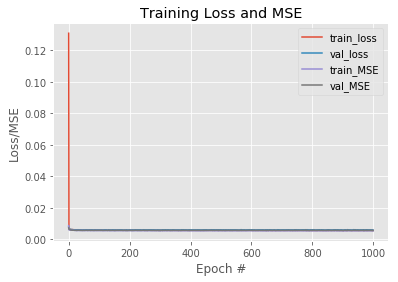

In [30]:
from keras.callbacks import TensorBoard
from tensorflow.keras import backend

EPOCHS = 1000
LEARNING_RATE = 1e-3
DECAY = LEARNING_RATE / EPOCHS
DROPOUT = 0.2
model_name = 'lem_nnlm128_final' + str(DROPOUT) + '_dropout'
X_train, X_test, Y_train, Y_test = lem_set

reset_random()
# tf.reset_default_graph()

def train_final(x_train, y_train, x_val, y_val, model_name):
  
  model = Sequential()
  
  hub_layer = get_tfhub_layer(tfhub_nnlm128, False)
  model.add(hub_layer)
  
  model.add(layers.Dense(1024,activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.Dropout(DROPOUT, seed=SEED))
  model.add(layers.Dense(512,activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.Dropout(DROPOUT, seed=SEED))
  model.add(layers.Dense(256,activation='relu'))
  model.add(layers.Dropout(DROPOUT, seed=SEED))
  model.add(layers.Dense(1,activation='sigmoid'))

  opt = optimizers.Adam(lr=LEARNING_RATE, decay=DECAY)

  model.compile(
      loss='mean_squared_error',
      optimizer=opt,
      metrics=['mse', 'mae', 'mape'],
  )

  # os.chdir(checkpoint_folder)
  tensorboard = TensorBoard(log_dir='logs') # config.RUN_LOG_DIR

  CHECKPOINT_FILE_PATH = model_name + '_checkpoint_best.hdf5'
  # checkpoint_path = os.path.join(parent_folder, CHECKPOINT_FILE_PATH)

  # Save checkpoints to local VM instance, can be downloaded after
  checkpoint = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_FILE_PATH,
                              monitor='mse',
                              verbose=1,
                              save_best_only=True,
                              mode='auto')

  reset_random()

  H = model.fit(x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=EPOCHS,
        shuffle=False,
        batch_size=32,
        use_multiprocessing=True,
        workers=8,
        callbacks=[
            tensorboard,
            # callback,
            checkpoint
            ]
    )
  
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, EPOCHS), H.history["mse"], label="train_MSE")
  plt.plot(np.arange(0, EPOCHS), H.history["val_mse"], label="val_MSE")
  # plt.plot(np.arange(0, config.NUM_EPOCHS), H.history["mean_absolute_error"], label="train_MAE")
  # plt.plot(np.arange(0, config.NUM_EPOCHS), H.history["val_mean_absolute_error"], label="val_MAE")
  # # plt.plot(np.arange(0, config.NUM_EPOCHS), H.history["mean_absolute_percentage_error"], label="train_MAPE")
  # plt.plot(np.arange(0, config.NUM_EPOCHS), H.history["val_mean_absolute_percentage_error"], label="val_MAPE")
  plt.title("Training Loss and MSE")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/MSE")
  plt.legend()
  plt.savefig('0.25drop_embeddings_loss_vs_MSE.png')

  MODEL = model_name + '.hdf5'

  model.save(MODEL)
  return model

# folder_name = 'models/spellcheck_nnlm128'

# parent_folder = os.path.join(folder_name, '{}_epochs'.format(EPOCHS))
# checkpoint_folder = os.path.join(parent_folder, 'checkpoints')
# output_folder = os.path.join(parent_folder, 'output')

# if not os.path.exists(folder_name):
#   os.makedirs(folder_name)
# if not os.path.exists(parent_folder):
#   os.makedirs(parent_folder)
# if not os.path.exists(checkpoint_folder):
#   os.makedirs(checkpoint_folder)
# if not os.path.exists(output_folder):
#   os.makedirs(output_folder)


model = train_final(X_train, Y_train, X_test, Y_test, model_name)
# # os.chdir(output_folder)
# MODEL = model_name + '.hdf5'
# model.save(MODEL)
score = Get_score(model.predict(X_test), Y_test)

In [27]:
score = Get_score(model.predict(X_test), Y_test)

The Spearman's correlation coefficient is: 0.466


In [26]:
!ls

hyperparameter_tuning  output


In [0]:
model = get_tfhub_model(tfhub_nnlm128, False)
name = tfhub_nnlm128.split('/')[-2] + '-test-confirmation'
model = train_model(model, X_train, Y_train, X_test, Y_test, name, epochs=20)
score = Get_score(model.predict(X_test), Y_test)

print(name + ': Score = ' + str(score))

Epoch 1/20
150/150 [==============================] - ETA: 0s - loss: 0.0101 - mse: 0.0101 - mae: 0.0748 - mape: 9.0901
Epoch 00001: mse improved from inf to 0.01014, saving model to /content/drive/My Drive/Colab Notebooks/CA684 ML Assignment/models/embeddings/output/nnlm-en-dim128-test-confirmation-comparison.hdf5
150/150 [==============================] - 36s 239ms/step - loss: 0.0101 - mse: 0.0101 - mae: 0.0748 - mape: 9.0901 - val_loss: 0.0051 - val_mse: 0.0052 - val_mae: 0.0560 - val_mape: 6.8340
Epoch 2/20
150/150 [==============================] - ETA: 0s - loss: 0.0060 - mse: 0.0060 - mae: 0.0609 - mape: 7.4004
Epoch 00002: mse improved from 0.01014 to 0.00603, saving model to /content/drive/My Drive/Colab Notebooks/CA684 ML Assignment/models/embeddings/output/nnlm-en-dim128-test-confirmation-comparison.hdf5
150/150 [==============================] - 37s 244ms/step - loss: 0.0060 - mse: 0.0060 - mae: 0.0609 - mape: 7.4004 - val_loss: 0.0055 - val_mse: 0.0055 - val_mae: 0.0562 -

In [0]:
# test saved models
from keras.models import load_model
model_name = '2dropout_nnlm128'
filepath = model_name + '.hdf5'
# filepath = model_name + '_checkpoint_best.hdf5'
model = load_model(model_name + '_checkpoint_best.hdf5', custom_objects={'KerasLayer':hub.KerasLayer}, compile=True)
# model = tf.keras.models.load_model(
#     filepath, custom_objects={'KerasLayer':hub.KerasLayer}, compile=True
# )
score = Get_score(model.predict(X_test), Y_test)
# MODEL = model_name + '.hdf5'
# model.save(MODEL)

# Long-term Training
Although the focus of this work is on the short-term memorability, the long-term is also predicted for completeness.

In [12]:
Ylong = labels[['long-term_memorability']].values
Xlong_train, Xlong_test, Ylong_train, Ylong_test = train_test_split(Xstop,Ylong, test_size=0.1, random_state=42)

model_name = 'long_stop_0.2dropout_nnlm128'
# model_name = model_name + '_checkpoint_best'

# long_model = train_final(Xlong_train, Ylong_train, Xlong_test, Ylong_test, model_name)
long_model = tf.keras.models.load_model(model_name + '.hdf5', custom_objects={'KerasLayer':hub.KerasLayer}, compile=True)

score = Get_score(long_model.predict(Xlong_test), Ylong_test)
# Xcap = df_cap['caption']
# Xspell = df_cap['spellcheck']
# Xstop = df_cap['stopwords']
# Xlem = df_cap['lemmatized']
# reset_random()
# Xcap_train, Xcap_test, Ycap_train, Ycap_test = train_test_split(Xcap,Y, test_size=0.1, random_state=42)
# Xspell_train, Xspell_test, Yspell_train, Yspell_test = train_test_split(Xspell,Y, test_size=0.1, random_state=42)
# Xstop_train, Xstop_test, Ystop_train, Ystop_test = train_test_split(Xstop,Y, test_size=0.1, random_state=42)
# Xlem_train, Xlem_test, Ylem_train, Ylem_test = train_test_split(Xlem,Y, test_size=0.1, random_state=42)

The Spearman's correlation coefficient is: 0.184
